In [506]:
import os
import opendatasets as od
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import kstest, mannwhitneyu, levene, ttest_ind, chi2_contingency, wilcoxon, spearmanr

In [507]:
od.download("https://www.kaggle.com/datasets/shashwatwork/dementia-prediction-dataset")

Skipping, found downloaded files in ".\dementia-prediction-dataset" (use force=True to force download)


In [508]:
# Check the contents of the downloaded folder
dataset_dir = './dementia-prediction-dataset'
print(os.listdir(dataset_dir))  # List the files in the dataset folder

# Load the CSV file (replace 'dementia_dataset.csv' with the correct file name if necessary)
csv_path = os.path.join(dataset_dir, 'dementia_dataset.csv')  
df = pd.read_csv(csv_path)

['dementia_dataset.csv']


In [509]:
df.head()

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,OAS2_0002,OAS2_0002_MR3,Demented,3,1895,M,R,80,12,NaN,22.0,0.5,1698,0.701,1.034


In [510]:
df.shape

(373, 15)

In [511]:
df.columns

Index(['Subject ID', 'MRI ID', 'Group', 'Visit', 'MR Delay', 'M/F', 'Hand',
       'Age', 'EDUC', 'SES', 'MMSE', 'CDR', 'eTIV', 'nWBV', 'ASF'],
      dtype='object')

Check the number of subjects.

In [513]:
df['Subject ID'].nunique()

150

In [514]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 373 entries, 0 to 372
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Subject ID  373 non-null    object 
 1   MRI ID      373 non-null    object 
 2   Group       373 non-null    object 
 3   Visit       373 non-null    int64  
 4   MR Delay    373 non-null    int64  
 5   M/F         373 non-null    object 
 6   Hand        373 non-null    object 
 7   Age         373 non-null    int64  
 8   EDUC        373 non-null    int64  
 9   SES         354 non-null    float64
 10  MMSE        371 non-null    float64
 11  CDR         373 non-null    float64
 12  eTIV        373 non-null    int64  
 13  nWBV        373 non-null    float64
 14  ASF         373 non-null    float64
dtypes: float64(5), int64(5), object(5)
memory usage: 43.8+ KB


Check for null values

In [516]:
df.isnull().sum()

Subject ID     0
MRI ID         0
Group          0
Visit          0
MR Delay       0
M/F            0
Hand           0
Age            0
EDUC           0
SES           19
MMSE           2
CDR            0
eTIV           0
nWBV           0
ASF            0
dtype: int64

Statistical description of the dataset.

In [518]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Visit,373.0,1.882038,0.922843,1.000,1.000,2.000,2.000,5.000
MR Delay,373.0,595.104558,635.485118,0.000,0.000,552.000,873.000,2639.000
Age,373.0,77.013405,7.640957,60.000,71.000,77.000,82.000,98.000
EDUC,373.0,14.597855,2.876339,6.000,12.000,15.000,16.000,23.000
SES,354.0,2.460452,1.134005,1.000,2.000,2.000,3.000,5.000
MMSE,371.0,27.342318,3.683244,4.000,27.000,29.000,30.000,30.000
CDR,373.0,0.290885,0.374557,0.000,0.000,0.000,0.500,2.000
eTIV,373.0,1488.128686,176.139286,1106.000,1357.000,1470.000,1597.000,2004.000
nWBV,373.0,0.729568,0.037135,0.644,0.700,0.729,0.756,0.837
ASF,373.0,1.195461,0.138092,0.876,1.099,1.194,1.293,1.587



## Features description:
*   Subject ID: Subject identification number.
*   MRI ID: Image identification number of an individual subject.
*   Group: Demented/Nondemented/Converted.
*   Visit: Number of subject visits.
*  MR Delay: Magnetic resonance (MR) delay is the delay time that is prior to the image procurement.
* M/F: Male/Female.
* Hand: Right/Left handed.
* Age: Subject age while scanning.
* EDUC: Subject education level (in years).
* SES: Socioeconomic status.
* MMSE: Mini-mental state examination score.
* CDR: Clinical dementia rating score.
* eTIV: Estimated total intracranial volume result.
* nWBV: Normalized whole brain volume result.
* ASF: Atlas scaling factor.







Replace 'Converted' with 'Demented' in the 'Group' column.

In [521]:
df['Group'] = df['Group'].replace('Converted', 'Demented')

### Seperating visits to different columns

In [523]:
# Pivot the DataFrame to add columns for each visit
df_pivot = df.pivot(index='Subject ID', columns='Visit', values=['Age', 'MR Delay', 'MMSE', 'CDR', 'eTIV', 'nWBV', 'ASF'])
df_pivot.columns = ['_'.join(map(str, col)).strip() for col in df_pivot.columns.values]
df_pivot.reset_index(inplace=True)

# Add EDUC and SES columns (taking the first occurrence for each Subject ID)
df_pivot = df_pivot.merge(df[['Subject ID', 'EDUC', 'SES', 'M/F', 'Group']].drop_duplicates(subset=['Subject ID']), on='Subject ID')

In [524]:
df_pivot.head()

,Subject ID,Age_1,Age_2,Age_3,Age_4,Age_5,MR Delay_1,MR Delay_2,MR Delay_3,MR Delay_4,...,nWBV_5,ASF_1,ASF_2,ASF_3,ASF_4,ASF_5,EDUC,SES,M/F,Group
0,OAS2_0001,87.0,88.0,NaN,NaN,NaN,0.0,457.0,NaN,NaN,...,NaN,0.883,0.876,NaN,NaN,NaN,14,2.0,M,Nondemented
1,OAS2_0002,75.0,76.0,80.0,NaN,NaN,0.0,560.0,1895.0,NaN,...,NaN,1.046,1.010,1.034,NaN,NaN,12,NaN,M,Demented
2,OAS2_0004,88.0,90.0,NaN,NaN,NaN,0.0,538.0,NaN,NaN,...,NaN,1.444,1.462,NaN,NaN,NaN,18,3.0,F,Nondemented
3,OAS2_0005,80.0,83.0,85.0,NaN,NaN,0.0,1010.0,1603.0,NaN,...,NaN,1.039,1.032,1.033,NaN,NaN,12,4.0,M,Nondemented
4,OAS2_0007,71.0,NaN,73.0,75.0,NaN,0.0,NaN,518.0,1281.0,...,NaN,1.293,NaN,1.286,1.279,NaN,16,NaN,M,Demented


In [525]:
df_pivot.shape

(150, 40)

In [526]:
df_pivot.columns

Index(['Subject ID', 'Age_1', 'Age_2', 'Age_3', 'Age_4', 'Age_5', 'MR Delay_1',
       'MR Delay_2', 'MR Delay_3', 'MR Delay_4', 'MR Delay_5', 'MMSE_1',
       'MMSE_2', 'MMSE_3', 'MMSE_4', 'MMSE_5', 'CDR_1', 'CDR_2', 'CDR_3',
       'CDR_4', 'CDR_5', 'eTIV_1', 'eTIV_2', 'eTIV_3', 'eTIV_4', 'eTIV_5',
       'nWBV_1', 'nWBV_2', 'nWBV_3', 'nWBV_4', 'nWBV_5', 'ASF_1', 'ASF_2',
       'ASF_3', 'ASF_4', 'ASF_5', 'EDUC', 'SES', 'M/F', 'Group'],
      dtype='object')

In [527]:
print(df_pivot.isnull().sum())

Subject ID      0
Age_1           0
Age_2           6
Age_3          92
Age_4         135
Age_5         144
MR Delay_1      0
MR Delay_2      6
MR Delay_3     92
MR Delay_4    135
MR Delay_5    144
MMSE_1          0
MMSE_2          7
MMSE_3         93
MMSE_4        135
MMSE_5        144
CDR_1           0
CDR_2           6
CDR_3          92
CDR_4         135
CDR_5         144
eTIV_1          0
eTIV_2          6
eTIV_3         92
eTIV_4        135
eTIV_5        144
nWBV_1          0
nWBV_2          6
nWBV_3         92
nWBV_4        135
nWBV_5        144
ASF_1           0
ASF_2           6
ASF_3          92
ASF_4         135
ASF_5         144
EDUC            0
SES             8
M/F             0
Group           0
dtype: int64


There are only enough subjects in the first and second visit, so we will keep them and drop the rest.

In [529]:
# Filter out patients without a second visit and those who didn't come to the second visit
df_pivot_filtered = df_pivot.dropna(subset=['MMSE_1', 'MMSE_2'])
missed_second_visit = df_pivot[(df_pivot['MMSE_2'].isna()) & (df_pivot['MMSE_3'].notna())]

# Create a combined dataset including those with data for the third visit
combined_data = pd.concat([df_pivot_filtered, missed_second_visit], ignore_index=True)

# Use values from the third visit for those who missed the second visit
features = ['Age', 'CDR', 'eTIV', 'nWBV', 'ASF']  # Add other features as needed

for feature in features:
    combined_data.loc[combined_data[f'{feature}_2'].isna(), f'{feature}_2'] = combined_data[f'{feature}_3']

# Also do this for MMSE and MR Delay as previously
combined_data.loc[combined_data['MMSE_2'].isna(), 'MMSE_2'] = combined_data['MMSE_3']
combined_data.loc[combined_data['MR Delay_2'].isna(), 'MR Delay_2'] = combined_data['MR Delay_3']

# Now drop third visit data as they are no longer needed
columns_3 = [f'{feature}_3' for feature in features] + ['MMSE_3', 'MR Delay_3']
columns_4 = [f'{feature}_4' for feature in features] + ['MMSE_4', 'MR Delay_4']
columns_5 = [f'{feature}_5' for feature in features] + ['MMSE_5', 'MR Delay_5']
columns_to_drop = columns_3 + columns_4 + columns_5
combined_data = combined_data.drop(columns=columns_to_drop)

# Checking how many patients are left after this adjustment
print(f"Number of patients after including third visit data: {combined_data.shape[0]}")

Number of patients after including third visit data: 149


In [530]:
combined_data.isnull().sum()

Subject ID    0
Age_1         0
Age_2         0
MR Delay_1    0
MR Delay_2    0
MMSE_1        0
MMSE_2        0
CDR_1         0
CDR_2         0
eTIV_1        0
eTIV_2        0
nWBV_1        0
nWBV_2        0
ASF_1         0
ASF_2         0
EDUC          0
SES           7
M/F           0
Group         0
dtype: int64

In [531]:
combined_data.columns

Index(['Subject ID', 'Age_1', 'Age_2', 'MR Delay_1', 'MR Delay_2', 'MMSE_1',
       'MMSE_2', 'CDR_1', 'CDR_2', 'eTIV_1', 'eTIV_2', 'nWBV_1', 'nWBV_2',
       'ASF_1', 'ASF_2', 'EDUC', 'SES', 'M/F', 'Group'],
      dtype='object')

In [532]:
combined_data.shape

(149, 19)

In [533]:
combined_data.head()

,Subject ID,Age_1,Age_2,MR Delay_1,MR Delay_2,MMSE_1,MMSE_2,CDR_1,CDR_2,eTIV_1,eTIV_2,nWBV_1,nWBV_2,ASF_1,ASF_2,EDUC,SES,M/F,Group
0,OAS2_0001,87.0,88.0,0.0,457.0,27.0,30.0,0.0,0.0,1987.0,2004.0,0.696,0.681,0.883,0.876,14,2.0,M,Nondemented
1,OAS2_0002,75.0,76.0,0.0,560.0,23.0,28.0,0.5,0.5,1678.0,1738.0,0.736,0.713,1.046,1.010,12,NaN,M,Demented
2,OAS2_0004,88.0,90.0,0.0,538.0,28.0,27.0,0.0,0.0,1215.0,1200.0,0.710,0.718,1.444,1.462,18,3.0,F,Nondemented
3,OAS2_0005,80.0,83.0,0.0,1010.0,28.0,29.0,0.0,0.5,1689.0,1701.0,0.712,0.711,1.039,1.032,12,4.0,M,Nondemented
4,OAS2_0008,93.0,95.0,0.0,742.0,30.0,29.0,0.0,0.0,1272.0,1257.0,0.698,0.703,1.380,1.396,14,2.0,F,Nondemented


Check for the group distribution.

In [535]:
combined_data['Group'].value_counts()

Group
Demented       77
Nondemented    72
Name: count, dtype: int64

In [536]:
combined_data.isnull().sum()

Subject ID    0
Age_1         0
Age_2         0
MR Delay_1    0
MR Delay_2    0
MMSE_1        0
MMSE_2        0
CDR_1         0
CDR_2         0
eTIV_1        0
eTIV_2        0
nWBV_1        0
nWBV_2        0
ASF_1         0
ASF_2         0
EDUC          0
SES           7
M/F           0
Group         0
dtype: int64

In [537]:
combined_data.nunique()

Subject ID    149
Age_1          34
Age_2          34
MR Delay_1      1
MR Delay_2    132
MMSE_1         13
MMSE_2         15
CDR_1           3
CDR_2           4
eTIV_1        130
eTIV_2        129
nWBV_1         90
nWBV_2         89
ASF_1         128
ASF_2         130
EDUC           12
SES             5
M/F             2
Group           2
dtype: int64

Identify numerical and categorical features

In [539]:
numerical_features = ['Age_1', 'MR Delay_2', 'MMSE_1', 
                        'eTIV_1', 'nWBV_1',
                      'ASF_1', 'EDUC']
categorical_features = ['CDR_1', 'SES', 'M/F', 'Group']

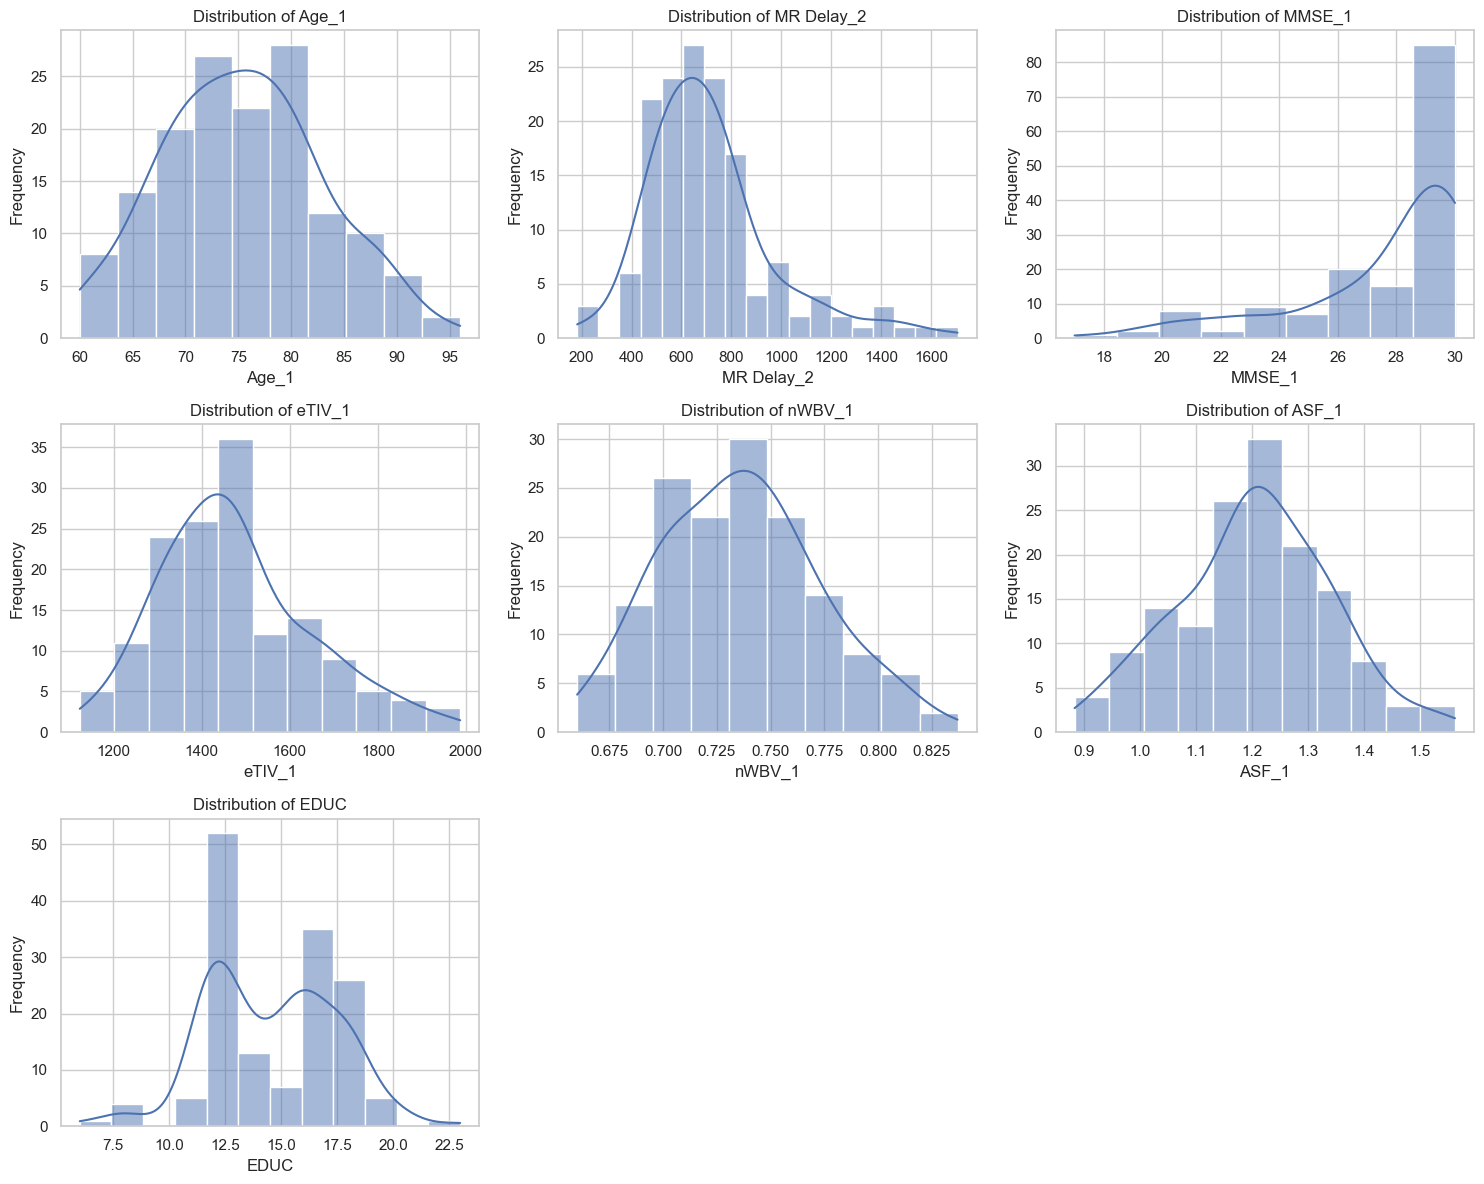

In [540]:
# Create a figure for numerical features
num_rows = (len(numerical_features) + 2) // 3  # Adjust for 3 columns
fig, axs = plt.subplots(num_rows, 3, figsize=(15, num_rows * 4))

for i, feature in enumerate(numerical_features):
    ax = axs[i // 3, i % 3]
    sns.histplot(combined_data[feature], ax=ax, kde=True)
    ax.set_title(f'Distribution of {feature}')
    ax.set_xlabel(feature)
    ax.set_ylabel('Frequency')

# Hide any empty subplots
for j in range(i + 1, num_rows * 3):
    fig.delaxes(axs.flatten()[j])

plt.tight_layout()
plt.show()

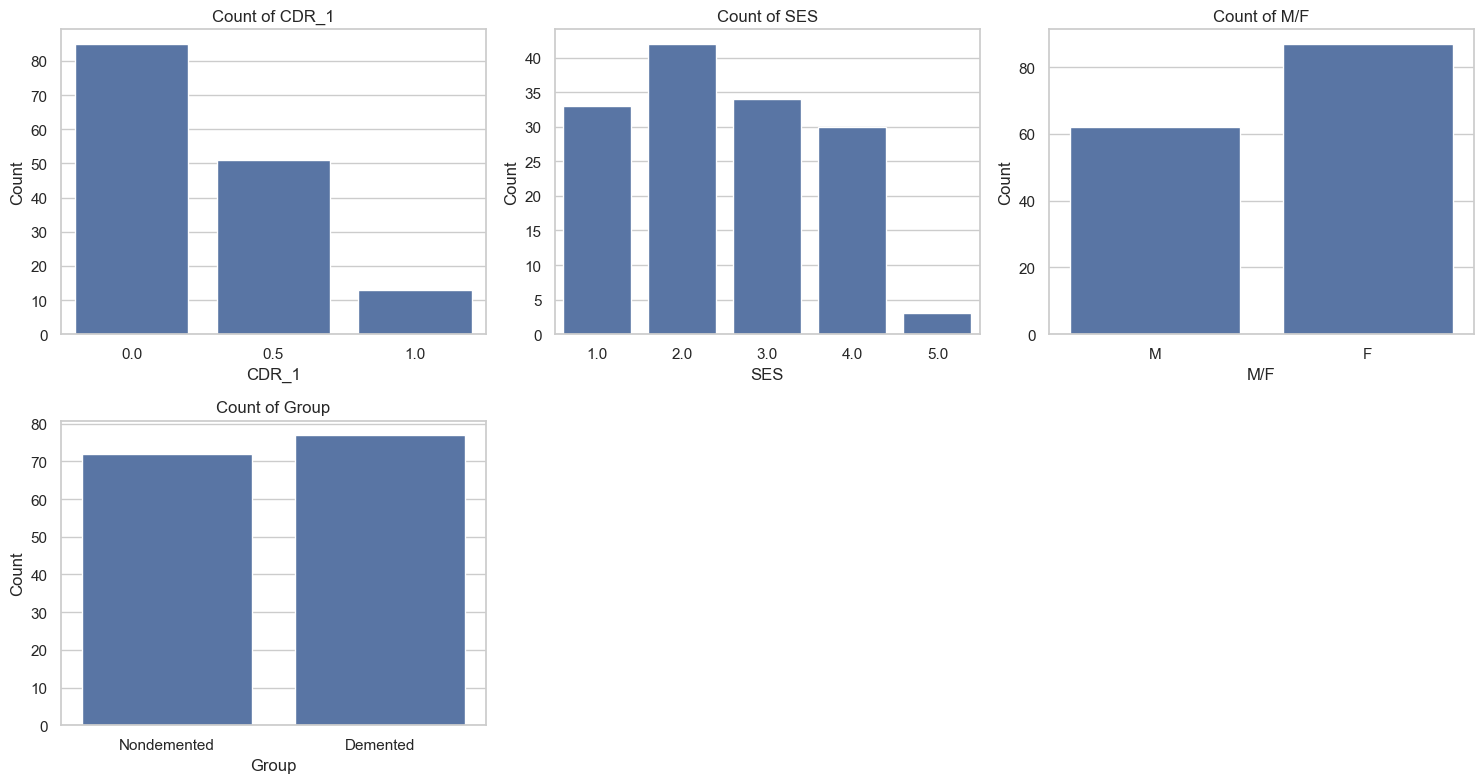

In [541]:
# Create a figure for categorical features
cat_rows = (len(categorical_features) + 2) // 3
fig, axs = plt.subplots(cat_rows, 3, figsize=(15, cat_rows * 4))

for i, feature in enumerate(categorical_features):
    ax = axs[i // 3, i % 3]
    sns.countplot(x=feature, data=combined_data, ax=ax)
    ax.set_title(f'Count of {feature}')
    ax.set_xlabel(feature)
    ax.set_ylabel('Count')

# Hide any empty subplots
for j in range(i + 1, cat_rows * 3):
    fig.delaxes(axs.flatten()[j])

plt.tight_layout()
plt.show()

## Statistical tests

Create a dataframe to store results.

In [544]:
demented_df = combined_data[combined_data['Group'] == 'Demented']
nondemented_df = combined_data[combined_data['Group'] == 'Nondemented']

### Normality tests

In [546]:
# Kolmogorov-Smirnov Test
def ks_test(data, feat):
  ks_stat, ks_p = kstest(data[feat], 'norm', args=(np.mean(data[feat]), np.std(data[feat])))
  return ks_stat, ks_p

Check which features are normally distributed.

In [548]:
# Initialize a list to store results
results = []

# Loop through numerical features and perform the KS test
for f in numerical_features:
    # Test for the demented group
    ks_stat_d, ks_p_d = ks_test(demented_df, f)
    if ks_p_d > 0.05:
        results.append({'feature': f, 'group': 'Demented', 'statistic': ks_stat_d, 'p-value': ks_p_d, 'test': 'KS Test'})
    
    # Test for the nondemented group
    ks_stat_nd, ks_p_nd = ks_test(nondemented_df, f)
    if ks_p_nd > 0.05:
        results.append({'feature': f, 'group': 'Nondemented', 'statistic': ks_stat_nd, 'p-value': ks_p_nd, 'test': 'KS Test'})

# Create DataFrame from the results list
results_df = pd.DataFrame(results)

# Print features that are normal for both groups
both_norm_feat = results_df['feature'].unique()
if len(both_norm_feat) > 0:
    print("Features with normal distribution in both groups:")
    for feature in both_norm_feat:
        print(feature)

Features with normal distribution in both groups:
Age_1
MR Delay_2
MMSE_1
eTIV_1
nWBV_1
ASF_1


For the non-normal features, we will perform the Mann Whitney U test.

### Mann Whitney U test

#### 'EDUC' feature

In [552]:
# Divide into groups
group1 = demented_df['EDUC']
group2 = nondemented_df['EDUC']

# Perform the Mann-Whitney U test
stat, p_value = mannwhitneyu(group1, group2)

# Create a new DataFrame for the results
new_result = pd.DataFrame({
    'feature': ['EDUC'],
    'group': ['Both'],
    'statistic': [stat],
    'p-value': [p_value],
    'test': ['Mann-Whitney U Test'] 
})

# Concatenate with results_df
results_df = pd.concat([results_df, new_result], ignore_index=True)

# Print the results
print(f'Mann-Whitney U Test Statistic: {stat}')
print(f'p-value: {p_value}')

Mann-Whitney U Test Statistic: 2099.0
p-value: 0.00917151338646463


#### 'SES' feature

In [554]:
# Divide into groups and drop NaN values
group1 = demented_df.dropna(subset=['SES'])['SES']
group2 = nondemented_df.dropna(subset=['SES'])['SES']

# Perform the Mann-Whitney U test
stat, p_value = mannwhitneyu(group1, group2)

# Create a new DataFrame for the results
new_result = pd.DataFrame({
    'feature': ['SES'],
    'group': ['Both'],
    'statistic': [stat],
    'p-value': [p_value],
    'test': ['Mann-Whitney U Test']  # Add the test name
})

# Concatenate with results_df
results_df = pd.concat([results_df, new_result], ignore_index=True)

# Print the results
print(f'Mann-Whitney U Test Statistic: {stat}')
print(f'p-value: {p_value}')

Mann-Whitney U Test Statistic: 2702.0
p-value: 0.4445694571201432


### Independent Samples T-Test

Make sure the variances of the two groups are roughly equal using Levene's test.

In [557]:
for f in ['Age_1', 'nWBV_1', 'eTIV_1']:
    group1 = demented_df[f]
    group2 = nondemented_df[f]

    # Perform Levene's test
    stat, p_value = levene(group1, group2)

    # Create a new DataFrame for the results
    new_result = pd.DataFrame({
        'feature': [f],
        'group': ['Both'],
        'statistic': [stat],
        'p-value': [p_value],
        'test': ['Levene\'s Test'] 
    })

    # Concatenate with results_df
    results_df = pd.concat([results_df, new_result], ignore_index=True)

    # Output the result
    print(f"{f}")
    print(f'Levene\'s Test Statistic: {stat}')
    print(f'p-value: {p_value}')
    print()

Age_1
Levene's Test Statistic: 1.837932409225935
p-value: 0.17727259296596184

nWBV_1
Levene's Test Statistic: 1.8047719358860415
p-value: 0.18120686789352203

eTIV_1
Levene's Test Statistic: 1.1114802028125428
p-value: 0.29349015423658026



Indeed the variances between the Demented and Nondemented groups are not significantly different for these features.

In [559]:
# List of features to test
features = ['Age_1', 'nWBV_1', 'ASF_1']

# Perform t-tests for each feature
for feature in features:
    # Extract data for each group
    group1 = demented_df[feature]
    group2 = nondemented_df[feature]

    # Perform the independent samples t-test
    t_stat, p_value = ttest_ind(group1, group2, equal_var=True)  # equal_var=True assumes equal variances

    # Create a new DataFrame for the results
    new_result = pd.DataFrame({
        'feature': [feature],
        'group': ['Both'],
        'statistic': [t_stat],
        'p-value': [p_value],
        'test': ['T-test']  # Add the test name
    })

    # Concatenate with results_df
    results_df = pd.concat([results_df, new_result], ignore_index=True)

    # Output the result
    print(f"{feature}:")
    print(f'T-statistic: {t_stat}')
    print(f'p-value: {p_value}')
    print()

Age_1:
T-statistic: 0.04012484772841151
p-value: 0.9680480363991475

nWBV_1:
T-statistic: -3.346431290943628
p-value: 0.0010393521246039239

ASF_1:
T-statistic: 0.09425811147661887
p-value: 0.9250324807164405



In [560]:
# Calculate descriptive statistics for nWBV by group
mean_nwbv_demented = combined_data[combined_data['Group'] == 'Demented']['nWBV_1'].mean()
std_nwbv_demented = combined_data[combined_data['Group'] == 'Demented']['nWBV_1'].std()

mean_nwbv_nondemented = combined_data[combined_data['Group'] == 'Nondemented']['nWBV_1'].mean()
std_nwbv_nondemented = combined_data[combined_data['Group'] == 'Nondemented']['nWBV_1'].std()

print(f"Mean nWBV (Demented): {mean_nwbv_demented}, Std: {std_nwbv_demented}")
print(f"Mean nWBV (Nondemented): {mean_nwbv_nondemented}, Std: {std_nwbv_nondemented}")

Mean nWBV (Demented): 0.7267142857142858, Std: 0.032060738878628633
Mean nWBV (Nondemented): 0.746125, Std: 0.03862128782471447


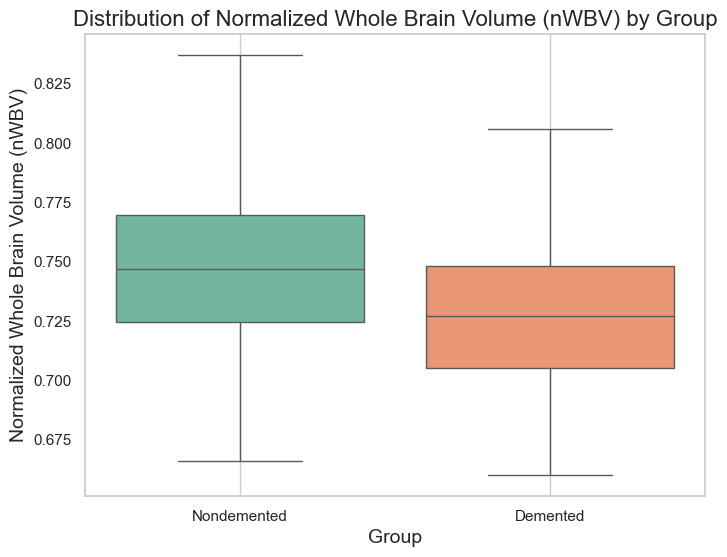

In [561]:
# Set the palette
palette = sns.color_palette('Set2')

plt.figure(figsize=(8, 6))
sns.boxplot(x='Group', y='nWBV_1', data=combined_data, hue='Group', palette='Set2', legend=False)

# Add titles and labels
plt.title('Distribution of Normalized Whole Brain Volume (nWBV) by Group', fontsize=16)
plt.xlabel('Group', fontsize=14)
plt.ylabel('Normalized Whole Brain Volume (nWBV)', fontsize=14)

# Show the plot
plt.grid()
plt.show()

### Chi-Square test

In [563]:
# Create a contingency table
contingency_table = pd.crosstab(combined_data['M/F'], combined_data['Group'])

# Perform Chi-Square test
stat, p_value, dof, expected = chi2_contingency(contingency_table)

# Store the results in results_df
results_df = pd.concat([results_df, pd.DataFrame({
    'feature': ['M/F'],
    'group': ['Both'],
    'statistic': [stat],
    'p-value': [p_value],
    'test': ['Chi-Square'] 
})], ignore_index=True)

# Output the results
print('Contingency Table:')
print(contingency_table)

print('\nExpected Frequencies:')
print(pd.DataFrame(expected, index=contingency_table.index, columns=contingency_table.columns))

print(f'\nChi-Square Statistic: {stat}')
print(f'p-value: {p_value}')

Contingency Table:
Group  Demented  Nondemented
M/F                         
F            37           50
M            40           22

Expected Frequencies:
Group   Demented  Nondemented
M/F                          
F      44.959732    42.040268
M      32.040268    29.959732

Chi-Square Statistic: 6.15560918155815
p-value: 0.013099599069622993


### Paired comparisons

#### MMSE change

In [566]:
# Perform Wilcoxon Signed-Rank Test for the Demented group
stat_demented, p_value_demented = wilcoxon(demented_df['MMSE_1'], demented_df['MMSE_2'])
print(f'Demented Group - Wilcoxon Test Statistic: {stat_demented}, p-value: {p_value_demented}')

results_df = pd.concat([results_df, pd.DataFrame({
    'feature': ['MMSE_1 vs MMSE_2'],
    'group': ['Demented'],
    'statistic': [stat_demented],
    'p-value': [p_value_demented],
    'test': ['Wilcoxon Signed-Rank']  
})], ignore_index=True)

# Perform Wilcoxon Signed-Rank Test for the Nondemented group
stat_nondemented, p_value_nondemented = wilcoxon(nondemented_df['MMSE_1'], nondemented_df['MMSE_2'])
print(f'Nondemented Group - Wilcoxon Test Statistic: {stat_nondemented}, p-value: {p_value_nondemented}')

results_df = pd.concat([results_df, pd.DataFrame({
    'feature': ['MMSE_1 vs MMSE_2'],
    'group': ['Nondemented'],
    'statistic': [stat_nondemented],
    'p-value': [p_value_nondemented],
    'test': ['Wilcoxon Signed-Rank'] 
})], ignore_index=True)

Demented Group - Wilcoxon Test Statistic: 540.0, p-value: 0.005393782068663349
Nondemented Group - Wilcoxon Test Statistic: 414.5, p-value: 0.4514454726470859


#### eTIV change

In [568]:
# Perform Wilcoxon Signed-Rank Test for the Demented group
stat_demented, p_value_demented = wilcoxon(demented_df['eTIV_1'], demented_df['eTIV_2'])
print(f'Demented Group - Wilcoxon Test Statistic: {stat_demented}, p-value: {p_value_demented}')

# Store the results in results_df
results_df = pd.concat([results_df, pd.DataFrame({
    'feature': ['eTIV_1 vs eTIV_2'],
    'group': ['Demented'],
    'statistic': [stat_demented],
    'p-value': [p_value_demented],
    'test': ['Wilcoxon Signed-Rank']  
})], ignore_index=True)

# Perform Wilcoxon Signed-Rank Test for the Nondemented group
stat_nondemented, p_value_nondemented = wilcoxon(nondemented_df['eTIV_1'], nondemented_df['eTIV_2'])
print(f'Nondemented Group - Wilcoxon Test Statistic: {stat_nondemented}, p-value: {p_value_nondemented}')

# Store the results in results_df
results_df = pd.concat([results_df, pd.DataFrame({
    'feature': ['eTIV_1 vs eTIV_2'],
    'group': ['Nondemented'],
    'statistic': [stat_nondemented],
    'p-value': [p_value_nondemented],
    'test': ['Wilcoxon Signed-Rank']  
})], ignore_index=True)

Demented Group - Wilcoxon Test Statistic: 797.5, p-value: 0.0009164318621701927
Nondemented Group - Wilcoxon Test Statistic: 1067.5, p-value: 0.16648981445088074


The change in 'eTIV' is significant only in the demented group. Let's explore this further:

In [570]:
combined_data['eTIV_change'] = combined_data['eTIV_2'] - combined_data['eTIV_1']

In [571]:
# Percentage of patients with negative (decreasing) nWBV change
demented_decreasing = (combined_data[combined_data['Group'] == 'Demented']['eTIV_change'] < 0).mean() * 100
nondemented_decreasing = (combined_data[combined_data['Group'] == 'Nondemented']['eTIV_change'] < 0).mean() * 100

print(f"Percentage of Demented Patients with Decreasing nWBV: {demented_decreasing}%")
print(f"Percentage of Nondemented Patients with Decreasing nWBV: {nondemented_decreasing}%")

Percentage of Demented Patients with Decreasing nWBV: 37.66233766233766%
Percentage of Nondemented Patients with Decreasing nWBV: 45.83333333333333%


In [572]:
# Calculate mean and standard deviation for Visit 1
mean_eTIV_1 = demented_df['eTIV_1'].mean()
std_eTIV_1 = demented_df['eTIV_1'].std()

# Calculate mean and standard deviation for Visit 2
mean_eTIV_2 = demented_df['eTIV_2'].mean()
std_eTIV_2 = demented_df['eTIV_2'].std()

print(f"Visit 1 - Mean eTIV: {mean_eTIV_1:.2f}, Std: {std_eTIV_1:.2f}")
print(f"Visit 2 - Mean eTIV: {mean_eTIV_2:.2f}, Std: {std_eTIV_2:.2f}")

Visit 1 - Mean eTIV: 1473.05, Std: 164.43
Visit 2 - Mean eTIV: 1485.09, Std: 166.65


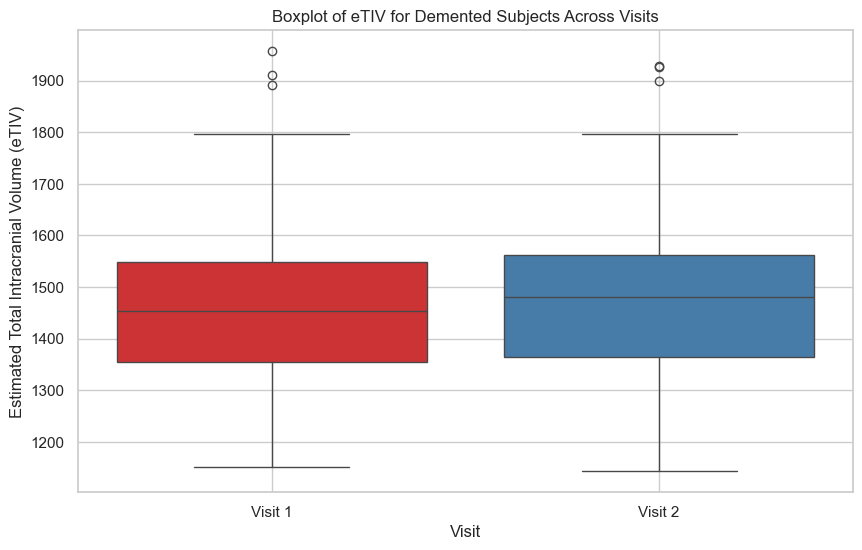

In [573]:
# Sample data
data = {
    'Visit': ['Visit 1'] * len(demented_df) + ['Visit 2'] * len(demented_df),
    'eTIV': list(demented_df['eTIV_1']) + list(demented_df['eTIV_2'])
}

# Create a DataFrame
eTIV_df = pd.DataFrame(data)

# Create the boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Visit', y='eTIV', hue='Visit', data=eTIV_df, palette='Set1', legend=False)
plt.title('Boxplot of eTIV for Demented Subjects Across Visits')
plt.xlabel('Visit')
plt.ylabel('Estimated Total Intracranial Volume (eTIV)')
plt.grid(True)
plt.savefig('eTIV_boxplot.png')  # Save the figure
plt.show()

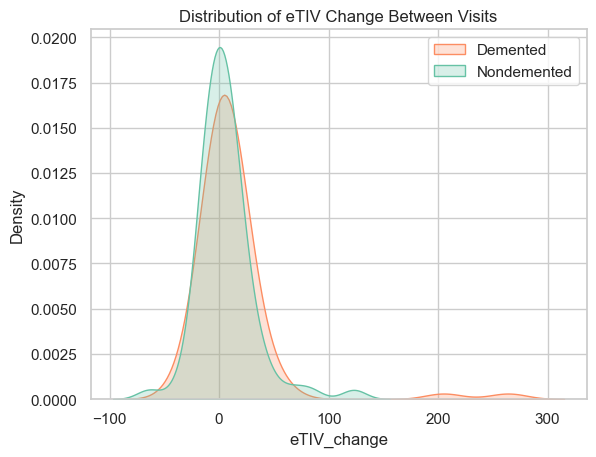

In [574]:
# KDE plot of eTIV change for each group with switched colors
sns.kdeplot(combined_data[combined_data['Group'] == 'Demented']['eTIV_change'], color=palette[1], label='Demented', fill=True)  # Orange
sns.kdeplot(combined_data[combined_data['Group'] == 'Nondemented']['eTIV_change'], color=palette[0], label='Nondemented', fill=True)  # Green

# Set the title and labels
plt.title('Distribution of eTIV Change Between Visits')
plt.legend()
plt.grid(True)
plt.show()

#### nWBV change

In [576]:
# Perform Wilcoxon Signed-Rank Test for the Demented group
stat_demented, p_value_demented = wilcoxon(demented_df['nWBV_1'], demented_df['nWBV_2'])
print(f'Demented Group - Wilcoxon Test Statistic: {stat_demented}, p-value: {p_value_demented}')

# Store the results in results_df
results_df = pd.concat([results_df, pd.DataFrame({
    'feature': ['nWBV_1 vs nWBV_2'],
    'group': ['Demented'],
    'statistic': [stat_demented],
    'p-value': [p_value_demented],
    'test': ['Wilcoxon Signed-Rank']  
})], ignore_index=True)

# Perform Wilcoxon Signed-Rank Test for the Nondemented group
stat_nondemented, p_value_nondemented = wilcoxon(nondemented_df['nWBV_1'], nondemented_df['nWBV_2'])
print(f'Nondemented Group - Wilcoxon Test Statistic: {stat_nondemented}, p-value: {p_value_nondemented}')

# Store the results in results_df
results_df = pd.concat([results_df, pd.DataFrame({
    'feature': ['nWBV_1 vs nWBV_2'],
    'group': ['Nondemented'],
    'statistic': [stat_nondemented],
    'p-value': [p_value_nondemented],
    'test': ['Wilcoxon Signed-Rank']  
})], ignore_index=True)

Demented Group - Wilcoxon Test Statistic: 204.0, p-value: 7.026542961814919e-11
Nondemented Group - Wilcoxon Test Statistic: 336.0, p-value: 1.1041116092011101e-07


The change in 'nWBV' is significant in both groups.

In [578]:
combined_data['nWBV_change'] = combined_data['nWBV_2'] - combined_data['nWBV_1']

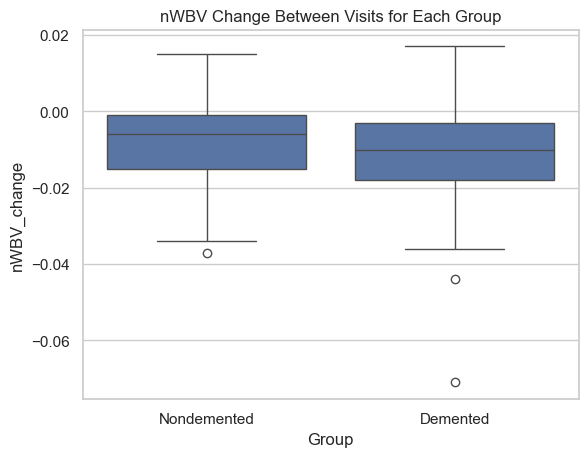

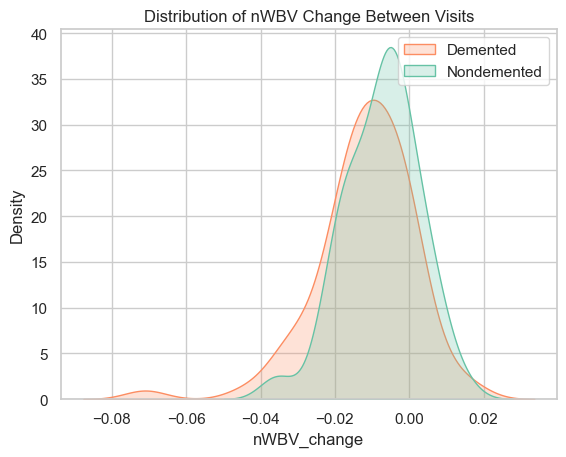

In [579]:
# Box plot of nWBV change for each group
sns.boxplot(x='Group', y='nWBV_change', data=combined_data)
plt.title('nWBV Change Between Visits for Each Group')
plt.show()

# Set the palette
palette = sns.color_palette('Set2')

# KDE plot of nWBV change for each group with switched colors
sns.kdeplot(combined_data[combined_data['Group'] == 'Demented']['nWBV_change'], color=palette[1], label='Demented', fill=True)  # Orange
sns.kdeplot(combined_data[combined_data['Group'] == 'Nondemented']['nWBV_change'], color=palette[0], label='Nondemented', fill=True)  # Green

# Set the title and labels
plt.title('Distribution of nWBV Change Between Visits')
plt.legend()
plt.grid(True)
plt.show()

In [580]:
# Percentage of patients with negative (decreasing) nWBV change
demented_decreasing = (combined_data[combined_data['Group'] == 'Demented']['nWBV_change'] < 0).mean() * 100
nondemented_decreasing = (combined_data[combined_data['Group'] == 'Nondemented']['nWBV_change'] < 0).mean() * 100

print(f"Percentage of Demented Patients with Decreasing nWBV: {demented_decreasing}%")
print(f"Percentage of Nondemented Patients with Decreasing nWBV: {nondemented_decreasing}%")

Percentage of Demented Patients with Decreasing nWBV: 85.71428571428571%
Percentage of Nondemented Patients with Decreasing nWBV: 76.38888888888889%


### Spearman's Correlation

In [582]:
# Initialize a list to store results
new_results = []

# Encode 'Group' feature
combined_data['Group_encoded'] = combined_data['Group'].map({'Demented': 1, 'Nondemented': 0})

# List of features to test
features = ['Age_1', 'eTIV_1', 'nWBV_1', 'EDUC']

# Compute Spearman correlations for features excluding 'SES'
for feature in features:
    spearman_corr, spearman_p = spearmanr(combined_data[feature], combined_data['Group_encoded'])
    new_results.append({
        'feature': feature,
        'group': 'Both',
        'statistic': spearman_corr,
        'p-value': spearman_p,
        'test': 'Spearman Correlation'
    })
    print(f'Spearman Correlation between {feature} and Group_encoded: {spearman_corr:.3f}, p-value: {spearman_p:.3f}')

# Drop rows with missing values in 'SES' and compute Spearman correlation with 'Group_encoded'
cleaned_data = combined_data.dropna(subset=['SES'])
spearman_corr_ses, spearman_p_ses = spearmanr(cleaned_data['SES'], cleaned_data['Group_encoded'])
new_results.append({
    'feature': 'SES',
    'group': 'Both',
    'statistic': spearman_corr_ses,
    'p-value': spearman_p_ses,
    'test': 'Spearman Correlation'
})
print(f'Spearman Correlation between SES and Group_encoded: {spearman_corr_ses:.3f}, p-value: {spearman_p_ses:.3f}')

# Create a DataFrame from the new results and concatenate with existing results_df
new_results_df = pd.DataFrame(new_results)
results_df = pd.concat([results_df, new_results_df], ignore_index=True)

Spearman Correlation between Age_1 and Group_encoded: 0.006, p-value: 0.940
Spearman Correlation between eTIV_1 and Group_encoded: -0.011, p-value: 0.893
Spearman Correlation between nWBV_1 and Group_encoded: -0.262, p-value: 0.001
Spearman Correlation between EDUC and Group_encoded: -0.214, p-value: 0.009
Spearman Correlation between SES and Group_encoded: 0.065, p-value: 0.445


All the correlations are either not significant or not meaningful.

### Results

Multiple comparisons correction using Dunn Sidak method.

In [586]:
# Define original alpha level
alpha = 0.05

# Number of tests (update this to match your actual number of tests)
n_tests = len(results_df)  # or set this manually to the number of unique tests performed

# Calculate Dunn-Sidak adjusted alpha
adjusted_alpha = 1 - (1 - alpha)**(1/n_tests)

print(f"Adjusted_alpha = {adjusted_alpha}")

# Add 'significant' column to results_df
results_df['significant'] = results_df['p-value'].apply(lambda p: 'Yes' if p < adjusted_alpha else 'No')

# Display the updated results DataFrame
display(results_df)

Adjusted_alpha = 0.00165325426664098


,feature,group,statistic,p-value,test,significant
0,Age_1,Demented,0.081887,6.497977e-01,KS Test,No
1,Age_1,Nondemented,0.068647,8.633548e-01,KS Test,No
2,MR Delay_2,Demented,0.149587,5.724812e-02,KS Test,No
3,MR Delay_2,Nondemented,0.123025,2.079939e-01,KS Test,No
4,MMSE_1,Demented,0.144489,7.247882e-02,KS Test,No
5,eTIV_1,Demented,0.126723,1.546172e-01,KS Test,No
6,eTIV_1,Nondemented,0.109035,3.344030e-01,KS Test,No
7,nWBV_1,Demented,0.052756,9.752295e-01,KS Test,No
8,nWBV_1,Nondemented,0.064033,9.108898e-01,KS Test,No
9,ASF_1,Demented,0.082209,6.450082e-01,KS Test,No


In [587]:
display(results_df[results_df['significant'] == 'Yes'])

,feature,group,statistic,p-value,test,significant
17,nWBV_1,Both,-3.346431,1.039352e-03,T-test,Yes
22,eTIV_1 vs eTIV_2,Demented,797.500000,9.164319e-04,Wilcoxon Signed-Rank,Yes
24,nWBV_1 vs nWBV_2,Demented,204.000000,7.026543e-11,Wilcoxon Signed-Rank,Yes
25,nWBV_1 vs nWBV_2,Nondemented,336.000000,1.104112e-07,Wilcoxon Signed-Rank,Yes
28,nWBV_1,Both,-0.261860,1.255478e-03,Spearman Correlation,Yes
